<a href="https://colab.research.google.com/github/alicenyms/Python-Notebook/blob/main/LSTM_Model_for_Hang_Seng_Index_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM Model for Hang Seng Index Prediction

##Pip install yfinance library

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 302 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


##Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data
from datetime import datetime
#import matplotlib.pyplot as plt
from pylab import plt
import yfinance as yf
yf.pdr_override()

##Load the Hang Seng Index Data using DataReader of pandas
The start date and end date are defined using datatime library. “start” and “end” are used as the arguments for the pandas DataReader to extract the Hang Seng Index Data within the defined period from yahoo finance. The closing price column was extracted with the date to form the data frame “df”. There is total 1598 data inside the dataset.

In [5]:
start = datetime.strptime('2015-01-01','%Y-%m-%d')
end = datetime.strptime('2021-6-30','%Y-%m-%d')
df = data.DataReader('^HSI',start=start, end=end, data_source='yahoo')
df = df['Close']
df

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02    23721.300781
2015-01-05    23721.320312
2015-01-06    23485.410156
2015-01-07    23681.259766
2015-01-08    23835.529297
                  ...     
2021-06-23    28817.070312
2021-06-24    28882.460938
2021-06-25    29288.220703
2021-06-28    29268.300781
2021-06-29    28994.099609
Name: Close, Length: 1598, dtype: float64

##Visualize the dataframe using plot function of Pylab library

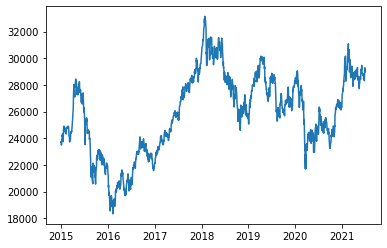

In [6]:
plt.plot(df)

##Data preparation

Data scaling is performed to satisfy the requirement of the LSTM model and to  obtain the best performance of model training.  A scaler model is defined by using the MinMaxScaler from sklearn.preprocessing. The action performed by the MinMaxScaler is to scale using the data inside the dataframe using equation (x-x.min)/(x.max – x.min). The data in dataframe were firstly converted into NumPy array, then they were scaled to a value between 0 and 1 to form a 1D array, and lastly, they were reshaped to a 2D array with 1 column and 1598 rows using reshape. 

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
rdata = scaler.fit_transform(np.array(df).reshape(-1,1))
rdata

array([[0.3641313 ],
       [0.36413262],
       [0.34822986],
       ...,
       [0.73939872],
       [0.73805591],
       [0.71957194]])

Since preparation is required for the time series data, therefore the rdata was firstly split into 65% and 35% of the total data as the intermediates. After that both parts were fed into the  TimeseriesGenerator from keras.preprocessing.sequence as the augments respecticely, to generate batches of training and testing data.  
 
According to the documentation of TensorFlow[1], the arguments taken by the TimesSeriesGenerator are: 

```` 
tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128 )
````
 
For the program used in Lecture 3,  “data”,”target”,length”and “batch_size” arguments were indicated in the TimeseriesGenerator. “data” argument shall be at 2D and is an indexable generator like a list or NumPy array that contains consecutive data points (timesteps). While “target” argument is corresponding to timesteps in data, and it shall have the same length as the “data” argument. “train_period” and “test_period” were used as the “data” and “target” arugments while the length of the consecutive timesteps was specified as 100  and the batch_size was specified as 1000 (just large enough to ensure the whole data are included into one batch). After that, the TimeseriesGenerator object “train” and “test” were converted to lists, and they were assigned to X_train, y_train, X_test and y_test respectively. The training dataset and testing dataset were ready to use. 

In [8]:
training_size=int(len(rdata)*0.65)
train_period,test_period=rdata[:training_size],rdata[training_size:]

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator
train = TimeseriesGenerator(train_period, train_period, length=100, batch_size=1000)
test = TimeseriesGenerator(test_period, test_period, length=100, batch_size=1000)

In [10]:
X_train, y_train = list(train)[0][0], list(train)[0][1]
X_test, y_test = list(test)[0][0], list(test)[0][1]

**Design the architecture of the LSTM model**

In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Different number of LSTM cell are used in two models.

Model 1: 50 LSTM cells in all the 3 LSTM layers.

Model 2: 200 LSTM cells for the first 2 LSTM layers and 100 for the third layer.

In [12]:
#Model 1
model1=Sequential() 
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1))) 
model1.add(LSTM(50,return_sequences=True)) 
model1.add(LSTM(50)) 
model1.add(Dense(1)) 
model1.compile(loss='mean_squared_error',optimizer='Adam')
#original_model.compile(loss='mean_squared_error',optimizer='SGD')
#original_model.compile(loss='mean_squared_error',optimizer='AdaDelta')

In [13]:
#Model 2
model2=Sequential() 
model2.add(LSTM(200,return_sequences=True,input_shape=(100,1))) 
model2.add(LSTM(200,return_sequences=True)) 
model2.add(LSTM(100)) 
model2.add(Dense(1)) 
model2.compile(loss='mean_squared_error',optimizer='Adam')

Using the .summary(), it is shown that the number of parameters of each layer are increased with the number of LSTM cells in each layer.


In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 200)          161600    
                                                                 
 lstm_4 (LSTM)               (None, 100, 200)          320800    
                                                                 
 lstm_5 (LSTM)               (None, 100)               120400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 602,901
Trainable params: 602,901
Non-trainable params: 0
_________________________________________________________________


**Model Building** <br>
X_train and y_train were fed into the model and X_test and y_test was used as the validation data, the epoch was set to 10 and the batch_size was set to 64. 


In [16]:
#Model 1
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
15/15 [==============================] - 13s 435ms/step - loss: 0.0626 - val_loss: 0.0218
Epoch 2/10
15/15 [==============================] - 3s 208ms/step - loss: 0.0106 - val_loss: 0.0049
Epoch 3/10
15/15 [==============================] - 4s 239ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 4/10
15/15 [==============================] - 3s 207ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 5/10
15/15 [==============================] - 3s 203ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 6/10
15/15 [==============================] - 3s 205ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 7/10
15/15 [==============================] - 3s 202ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 8/10
15/15 [==============================] - 4s 248ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 9/10
15/15 [==============================] - 3s 202ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 10/10
15/15 [==============================] - 3s 202ms/step - loss: 0.0026 - val_loss: 0.003

In [17]:
#Model 2
model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
15/15 [==============================] - 23s 1s/step - loss: 0.0309 - val_loss: 0.0062
Epoch 2/10
15/15 [==============================] - 15s 1s/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/10
15/15 [==============================] - 15s 1s/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/10
15/15 [==============================] - 15s 1s/step - loss: 0.0026 - val_loss: 0.0033
Epoch 5/10
15/15 [==============================] - 15s 1s/step - loss: 0.0026 - val_loss: 0.0031
Epoch 6/10
15/15 [==============================] - 15s 1s/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/10
15/15 [==============================] - 27s 2s/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/10
15/15 [==============================] - 22s 1s/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/10
15/15 [==============================] - 23s 2s/step - loss: 0.0019 - val_loss: 0.0024
Epoch 10/10
15/15 [==============================] - 23s 2s/step - loss: 0.0017 - val_loss: 0.0023


**Predict performance visualization** <br>
Inverse map operations to the true Hang Seng index were firstly done to X_train and X_test dataset, after that they were fed into the model for prediction. A graph that combines the prediction of X_train and X_test. 


In [18]:
#Model 1 
model1_train_pred = scaler.inverse_transform(model1.predict(X_train))
model1_test_pred = scaler.inverse_transform(model1.predict(X_test))

In [19]:
#Model 2
model2_train_pred = scaler.inverse_transform(model2.predict(X_train))
model2_test_pred = scaler.inverse_transform(model2.predict(X_test))

<function matplotlib.pyplot.show(*args, **kw)>

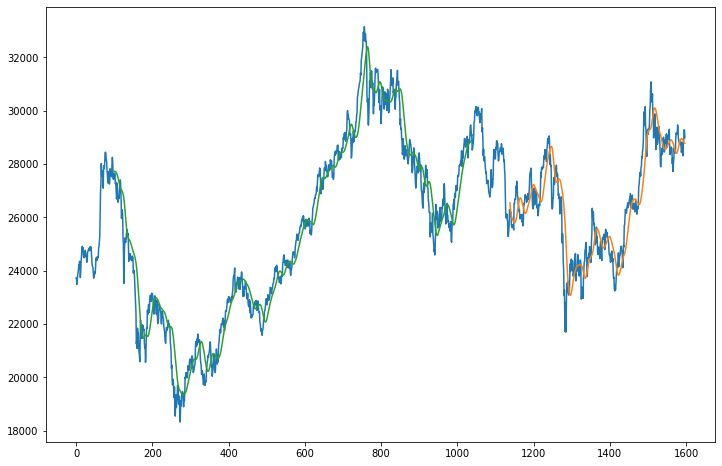

In [20]:
#Model 1
look_back=100
trainPredictPlot=np.empty_like(rdata)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(model1_train_pred)+look_back] = model1_train_pred

testPredictPlot=np.empty_like(rdata)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(model1_train_pred)+(look_back*2):len(rdata)] = model1_test_pred

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

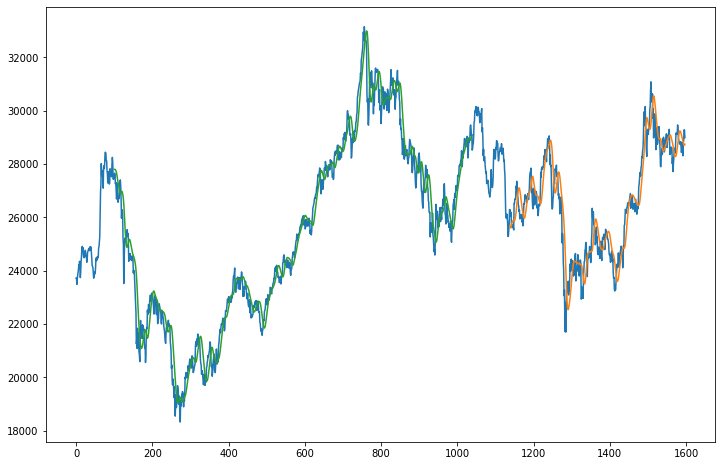

In [21]:
#Model 2
look_back=100
trainPredictPlot=np.empty_like(rdata)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(model2_train_pred)+look_back] = model2_train_pred

testPredictPlot=np.empty_like(rdata)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(model2_train_pred)+(look_back*2):len(rdata)] = model2_test_pred

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

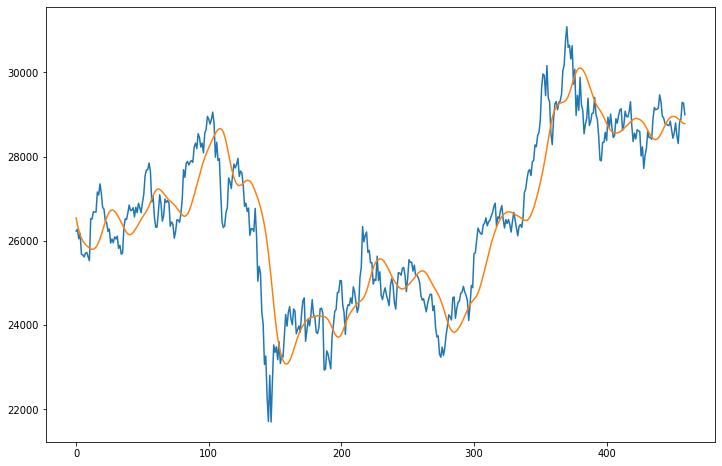

In [22]:
#Model 1
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata)[len(model1_train_pred)+(look_back*2):len(rdata)])
plt.plot(model1_test_pred)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

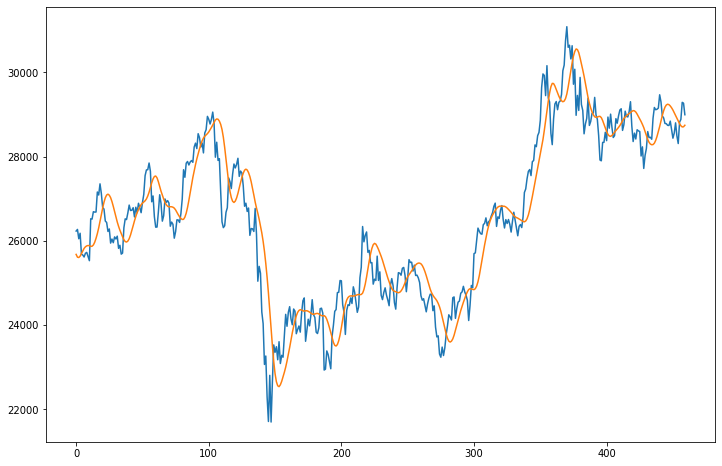

In [23]:
#Model 2
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata)[len(model2_train_pred)+(look_back*2):len(rdata)])
plt.plot(model2_test_pred)
plt.show

## Discussion
By comparing the performance graphs of both models, it is found that Model 2 shows a better prediction result on the testing dataset of the Hang Seng Index, the orange curve in the Model 2 is more fit to the true Hang Seng Index within the period.

When the number of LSTM cell units increases, the number of parameters in each layer will also increase under the same setting of retrun_sequences=True which the layer will output all the hidden states of each time step.  And for the Model 2, the total trainable parameters are nearly 12 times the Model 1. 
 
The reason why the Model 2 has better performance is that there are more parameters in each layer which results in higher flexibility for the model to tune the model to get better performance or accurate results during the training. The more parameters the model has, the better chance the weight can be tuned to fit the data more easily.
 
One of the drawbacks of increasing the number of parameters is the training process will require longer times. However, the training process for the new model only took about 3 minutes while the time of the Model 1 is about 40s as shown in the following figures. Therefore, it is acceptable since it was not taking much longer training time than the Model 1. 

 

